In [3]:
!python -V
!pip install seaborn torch
#!python -m pip install seaborn
#!python3 -m pip install seaborn

Python 3.8.5
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
df = pd.read_csv("/home/poki/Documents/pokerai-master/dataset.csv")
df.head()

,hand_id,street,player_position,players_in_pot,after_us_decision_players,current_pot_size,player_stack_size,percent_deposited_of_current_stack,pay_for_continue_play,current_bet,...,board_6_amount,board_5_amount,board_4_amount,board_3_amount,board_2_amount,board_spades_amount,board_hearts_amount,board_diamonds_amount,board_clubs_amount,ready_combination
0,2dgVE9A320200916155222_1,PREFLOP,2,0,4,15.0,2217.25,0.00000,10.0,10.0,...,0,0,0,0,0,0,0,0,0,AIR
1,2dgVE9A320200916155222_2,PREFLOP,4,1,4,36.3,2217.25,0.00000,21.3,21.3,...,0,0,0,0,0,0,0,0,0,AIR
2,2dgVE9A320200916155222_3,PREFLOP,5,1,3,45.0,2217.25,0.00000,30.0,30.0,...,0,0,0,0,0,0,0,0,0,AIR
3,2dgVE9A320200916155222_4,PREFLOP,0,0,1,15.0,2217.25,0.00225,5.0,10.0,...,0,0,0,0,0,0,0,0,0,AIR
4,2dgVE9A320200916155222_5,PREFLOP,1,1,1,40.0,2237.25,0.00445,15.0,25.0,...,0,0,0,0,0,0,0,0,0,AIR


<AxesSubplot:xlabel='action', ylabel='count'>

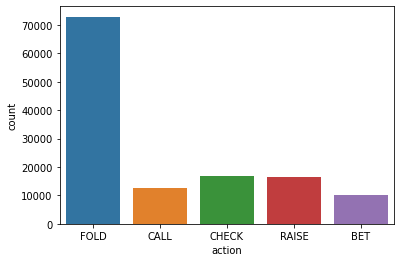

In [6]:
sns.countplot(x = 'action', data=df)

In [7]:
class2idx = {
    "FOLD":0,
    "RAISE":1,
    "CHECK":2,
    "BET":3,
    "CALL":4,
}
idx2class = {v: k for k, v in class2idx.items()}
df['action'].replace(class2idx, inplace=True)

In [8]:
y = df['action'].values
X = df.drop(columns=['action', 'hand_id']).iloc[:]

enc = OrdinalEncoder()
X = enc.fit_transform(X)
#print(enc.categories_)

# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [9]:
df.head()

,hand_id,street,player_position,players_in_pot,after_us_decision_players,current_pot_size,player_stack_size,percent_deposited_of_current_stack,pay_for_continue_play,current_bet,...,board_6_amount,board_5_amount,board_4_amount,board_3_amount,board_2_amount,board_spades_amount,board_hearts_amount,board_diamonds_amount,board_clubs_amount,ready_combination
0,2dgVE9A320200916155222_1,PREFLOP,2,0,4,15.0,2217.25,0.00000,10.0,10.0,...,0,0,0,0,0,0,0,0,0,AIR
1,2dgVE9A320200916155222_2,PREFLOP,4,1,4,36.3,2217.25,0.00000,21.3,21.3,...,0,0,0,0,0,0,0,0,0,AIR
2,2dgVE9A320200916155222_3,PREFLOP,5,1,3,45.0,2217.25,0.00000,30.0,30.0,...,0,0,0,0,0,0,0,0,0,AIR
3,2dgVE9A320200916155222_4,PREFLOP,0,0,1,15.0,2217.25,0.00225,5.0,10.0,...,0,0,0,0,0,0,0,0,0,AIR
4,2dgVE9A320200916155222_5,PREFLOP,1,1,1,40.0,2237.25,0.00445,15.0,25.0,...,0,0,0,0,0,0,0,0,0,AIR


In [10]:
#Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [11]:
def get_class_distribution(obj):
    count_dict = {
        "FOLD":0,
        "RAISE":0,
        "CHECK":0,
        "BET":0,
        "CALL":0,
    }

    for i in obj:
        if i == 0:
            count_dict['FOLD'] += 1
        elif i == 1:
            count_dict['RAISE'] += 1
        elif i == 2:
            count_dict['CHECK'] += 1
        elif i == 3: 
            count_dict['BET'] += 1
        elif i == 4: 
            count_dict['CALL'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

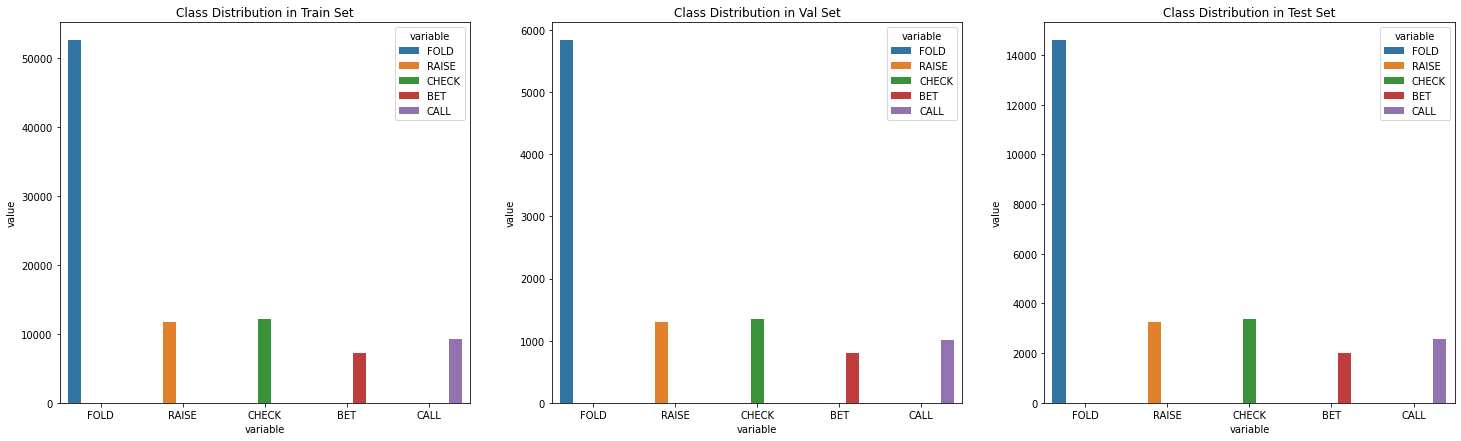

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [13]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [14]:
print(train_dataset)

In [15]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [16]:
print(target_list)

tensor([0, 1, 0,  ..., 1, 2, 0])


In [17]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
print(class_weights)

tensor([1.9045e-05, 8.5034e-05, 8.2196e-05, 1.3822e-04, 1.0898e-04])


In [18]:
class_weights_all = class_weights[target_list]

In [19]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [33]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007

In [42]:
NUM_FEATURES = 27
NUM_CLASSES = 5

In [43]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [44]:
class MulticlassClassification(nn.Module):
    
    
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [46]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class = NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=27, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [47]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [48]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [49]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss:{train_epoch_loss/len(train_loader):.5f} | Val Loss : {val_epoch_loss/len(val_loader):.5f} | Train Acc:{train_epoch_acc/len(train_loader):.3f}| Val Acc:{val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss:0.85713 | Val Loss : 0.86336 | Train Acc:65.794| Val Acc:59.093
Epoch 002: | Train Loss:0.78737 | Val Loss : 0.77393 | Train Acc:73.496| Val Acc:63.978
Epoch 003: | Train Loss:0.77280 | Val Loss : 0.77493 | Train Acc:76.771| Val Acc:63.804
Epoch 004: | Train Loss:0.76945 | Val Loss : 0.78559 | Train Acc:78.322| Val Acc:64.667
Epoch 005: | Train Loss:0.75679 | Val Loss : 0.78104 | Train Acc:80.407| Val Acc:63.251
Epoch 006: | Train Loss:0.75530 | Val Loss : 0.75479 | Train Acc:79.321| Val Acc:65.355
Epoch 007: | Train Loss:0.75202 | Val Loss : 0.78330 | Train Acc:79.080| Val Acc:65.229
Epoch 008: | Train Loss:0.74576 | Val Loss : 0.77706 | Train Acc:80.028| Val Acc:65.713
Epoch 009: | Train Loss:0.74485 | Val Loss : 0.80152 | Train Acc:79.666| Val Acc:64.230
Epoch 010: | Train Loss:0.73620 | Val Loss : 0.78659 | Train Acc:82.406| Val Acc:63.086
Epoch 011: | Train Loss:0.73912 | Val Loss : 0.79988 | Train Acc:81.527| Val Acc:63.823
Epoch 012: | Train Loss:0.73628 

KeyboardInterrupt: 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

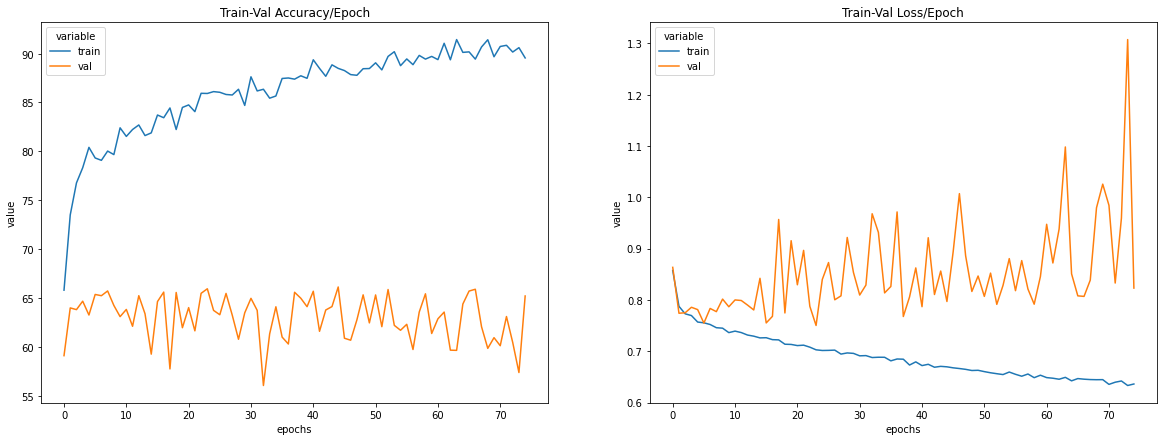

In [50]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')